# Benchmark SOCP Solvers with Limited Solve Time
Based on MCU benchmarks, we obtain time/iter for each solver. Then we can compute the maximum number of iterations for each solver given a fixed control frequency. We evaluate solution and performace of each solver with respect to this.

In [3]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using LinearAlgebra
using Printf
using ForwardDiff
using JuMP
using ECOS
using SCS
using Random
using PyPlot

  Activating environment at `~/SSD/Code/Julia/tinympc-dev-julia/rocket_landing_Zac/Project.toml`


In [4]:
include("JuMP_MPC.jl")
include("../LibTinyMPC_clean.jl")

reset_solver! (generic function with 1 method)

## Rocket Soft Landing

In [5]:
#Rocket landing
NSTATES = 6
NINPUTS = 3
NHORIZON = 21
NTOTAL = 301

# Initialize cache, settings, bounds, socs, workspace, solver

###### Cache
rho = 1e0
Kinf = zeros(NINPUTS,NSTATES)
Pinf = zeros(NSTATES,NSTATES)
Quu_inv = zeros(NINPUTS,NINPUTS)
AmBKt = zeros(NSTATES,NSTATES)
APf = zeros(NSTATES)
BPf = zeros(NINPUTS)
my_cache = TinyCache(rho, Kinf, Pinf, Quu_inv, AmBKt, APf, BPf)
#####

##### Settings
abs_pri_tol = 1e-2
abs_dua_tol = 1e-2
max_iter = 100
check_termination = 1
en_state_bound = 0  # ENABLE CONSTRAINTS OR NOT
en_input_bound = 1
en_state_soc = 0
en_input_soc = 1
my_stgs = TinySettings(abs_pri_tol, abs_dua_tol, max_iter, check_termination, en_state_bound, en_input_bound, en_state_soc, en_input_soc)
#####

###### Bounds
umin = -10.0*ones(NINPUTS, NHORIZON-1)
umax = 105*ones(NINPUTS, NHORIZON-1)
xmin = repeat([-4.5; -4.5; -0.5; -10; -10; -20], 1, NHORIZON)
xmax = repeat([4.5; 4.5; 100.0; 10; 10; 20], 1, NHORIZON)
z = zeros(NINPUTS, NHORIZON-1)
znew = zeros(NINPUTS, NHORIZON-1)
v = zeros(NSTATES, NHORIZON)
vnew = zeros(NSTATES, NHORIZON)
y = zeros(NINPUTS, NHORIZON-1)
g = zeros(NSTATES, NHORIZON)
my_bounds = TinyBounds(umin, umax, xmin, xmax, z, znew, v, vnew, y, g)
#####

##### SOCS
ncu = 1
ncx = 1
cu = [0.25, 0]  # 0.3 is the thrust coefficient
cx = [0.5, 0]
qcu = [3, 0]  # 3 is the dimensions of 1st cone
qux = [3, 0]
Acu = [1, 0]
Acx = [1, 0]
zc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
zcnew = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
vcnew = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
yc = [zeros(NINPUTS, NHORIZON-1), zeros(NINPUTS, NHORIZON-1)]
gc = [zeros(NSTATES, NHORIZON), zeros(NSTATES, NHORIZON)]
my_socs = TinySocs(ncu, ncx, cu, cx, qcu, qux, Acu, Acx, zc, zcnew, vc, vcnew, yc, gc)
#####

##### Workspace
x = zeros(NSTATES, NHORIZON)
u = zeros(NINPUTS, NHORIZON-1)
q = zeros(NSTATES, NHORIZON)
r = zeros(NINPUTS, NHORIZON-1)
p = zeros(NSTATES, NHORIZON)
d = zeros(NINPUTS, NHORIZON-1)
pri_res_state = 1.0
pri_res_input = 1.0
dua_res_state = 1.0
dua_res_input = 1.0
status = 0
iter = 0
Q = 1e3*I(NSTATES)
R = 1e0*I(NINPUTS)
Adyn = [1.0 0.0 0.0 0.05 0.0 0.0; 
    0.0 1.0 0.0 0.0 0.05 0.0; 
    0.0 0.0 1.0 0.0 0.0 0.05; 
    0.0 0.0 0.0 1.0 0.0 0.0; 
    0.0 0.0 0.0 0.0 1.0 0.0; 
    0.0 0.0 0.0 0.0 0.0 1.0]
Bdyn = [0.000125 0.0 0.0; 
    0.0 0.000125 0.0;
    0.0 0.0 0.000125; 
    0.005 0.0 0.0; 
    0.0 0.005 0.0; 
    0.0 0.0 0.005]
fdyn = [0.0, 0.0, -0.0122625, 0.0, 0.0, -0.4905] * 1

h = 0.05
t = h*(0:NTOTAL-1)
Xref = zeros(NSTATES, NTOTAL)
x0 = [4, 2, 20, -3, 2, -4.5]  # INITIAL STATE
# x0 = [4, 2, 20, -2, 1, -4.0]
x[:,1] = 1*x0
xg = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
for k = 1:NTOTAL
  Xref[:,k] = x0 + (xg - x0)*(k-1)/(NTOTAL-1)
end
# append zeros to Xref
Xref = hcat([Xref zeros(NSTATES, NHORIZON)])
Uref = repeat([0; 0; 10.0], 1, NTOTAL-1) 
Xref_hrz = 1*Xref[:,1:NHORIZON]
Uref_hrz = 1*Uref[:,1:NHORIZON-1]
# Could provide a better reference from other solvers

Qu = zeros(NINPUTS, NINPUTS)
my_work = TinyWorkspace(x, u, q, r, p, d, pri_res_state, pri_res_input, dua_res_state, dua_res_input, status, iter, Q, R, Adyn, Bdyn, fdyn, Xref_hrz, Uref_hrz, Qu, my_bounds, my_socs)
#####

# Solver
solver = TinySolver(my_stgs, my_cache, my_work)

TinySolver(TinySettings(0.01, 0.01, 100, 1, 0, 1, 0, 1), TinyCache(1.0, [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0]), TinyWorkspace([4.0 0.0 … 0.0 0.0; 2.0 0.0 … 0.0 0.0; … ; 2.0 0.0 … 0.0 0.0; -4.5 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], 1.0, 1.0, 1.0, 1.0, 0, 0, [1000.0 0.0 … 0.0 0.0; 0.0 1000.0 … 0.0 0.0; … ; 0.0 0.0 … 1000.0 0.0; 0.0 0.0 … 0.0 1000.0], [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 1.0], [1.0 0.0 … 0.0 

In [65]:
params = (
    Nh = NHORIZON,
    nx = NSTATES,
    nu = NINPUTS,
    ncx = en_state_bound,
    ncu = en_input_bound,
    ncg = 0,
    ncu_cone = en_input_soc,
    ncx_cone = en_state_soc,
    c_cone = cu,
    Q = Q*1+rho*I*0,
    R = R*1+rho*I*0,
    Qf = Q*1+rho*I*0,
    u_min = umin[:,1],
    u_max = umax[:,1],
    x_min = xmin[:,1],
    x_max = xmax[:,1],
    Xref = Xref_hrz,
    Uref = Uref_hrz,
    Adyn = Adyn,
    Bdyn = Bdyn,
    fdyn = fdyn,
);

function actuate!(utest)
    for i = 1:20
        utest = clamp.(utest, params.u_min, params.u_max)
        utest = project_soc(utest, cu[1], qcu[1])
        if norm(utest - clamp.(utest, params.u_min, params.u_max)) < 1e-1
            break
        end
    end
end


Xhrz = zeros(NSTATES, NHORIZON)
Xhrz[:,1] = x0*1
Uhrz = zeros(NINPUTS, NHORIZON-1)

# Horizon 32
tpis = [6962, 613.0, 45.0] # time (us) per iteration for solvers (taken for MCU)

3-element Vector{Float64}:
 6962.0
  613.0
   45.0

In [66]:
1e6/10/tpis[1]

14.363688595231256

## MPC

### Get data for one solver at one frequency

In [64]:
# MPC loop for each
# opti = "ECOS"
opti = "SCS"
# opti = "TinyMPC"

freq = 10.0  # Hz
optimizers = (
    # Use ECOS [1]
    JuMP.optimizer_with_attributes(ECOS.Optimizer, 
        "verbose"=>false, "abstol"=>1e-2, "reltol"=>1e-2, "maxit"=>round(Int, 1e6/freq/tpis[1])),
    # Use SCS [2]
    JuMP.optimizer_with_attributes(SCS.Optimizer, 
    "verbose"=>false, "eps_abs"=>1e-2, "eps_rel"=>1e-2, "max_iters"=>round(Int, 1e6/freq/tpis[2])),
    "TinyMPC")
solver.settings.max_iter = round(Int, 1e6/freq/tpis[3])

if (opti == "TinyMPC")
    compute_cache!(solver, Q, R)
end

info = SolnStats(0, 0, 0, 0, 0, 0, 0)

Random.seed!(1)
Xhist = zeros(NSTATES, NTOTAL)
Xhist[:,1] .= x0*1.1
Uhist = zeros(NINPUTS, NTOTAL-1)

Xhrz = 1*Xref[:,1:NHORIZON]
Xhrz[:,1] .= Xhist[:,1]
Uhrz = 1*Uref[:,1:NHORIZON-1]

for i = 1:NTOTAL-1
    # i%10 == 0 && print("i = ", i, "\n")
    # Get measurements
    solver.workspace.x[:,1] = Xhist[:,i] 
    Xhrz[:,1] .= Xhist[:,i]
    # print("x = ", solver.workspace.x[:,1], "\n")
    # display(solver.workspace.x[:,1])

    # Update references
    solver.workspace.Xref .= Xref[:,i:i+NHORIZON-1]
    params.Xref .= Xref[:,i:i+NHORIZON-1]
    # solver.workspace.Uref .= Uref[:,i:i+NHORIZON-2]
    # print("xref = ", solver.workspace.Xref[:,1], "\n")
    # display(solver.workspace.Xref[:,1])
    
    # Solve
    if (opti == "ECOS")
        solve_mpc_JuMP(optimizers[1], params, Xhrz, Uhrz; warm_start=false)
    elseif (opti == "SCS")
        solve_mpc_JuMP(optimizers[2], params, Xhrz, Uhrz; warm_start=false)        
    else
        solve_admm!(solver)
        Xhrz .= solver.workspace.x
        Uhrz .= solver.workspace.u
    end
    check_solution!(info, opti, params, Xhrz, Uhrz)    
    Uhist[:,i] .= Uhrz[:,1]
    
    # print("u = ", Uhist[:,i], "\n")
    # display(Uhist[:,i])

    # Simulate
    actuate!(Uhist[:,i])
    Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
    # display(Xhrz)
    # display(Uhrz)
end
info.tracking_error = norm(Xhist[:,NTOTAL] - xg)

1.3465442888572874

In [133]:
info

SolnStats(0.0, 0.0, 2.3624945503773915, 0.01426348227557467, 0.23624758370933918, 0.001666253324915339, 0.8725188674183626)

### Get data for all solvers at one frequency

In [68]:
infos = [SolnStats(0, 0, 0, 0, 0, 0, 0), SolnStats(0, 0, 0, 0, 0, 0, 0), SolnStats(0, 0, 0, 0, 0, 0, 0)]
if 1==1
    optis = ["ECOS", "SCS", "TinyMPC"]    
    freq = 500.0
    optimizers = (
        # Use ECOS [1]
        JuMP.optimizer_with_attributes(ECOS.Optimizer, 
            "verbose"=>false, "abstol"=>1e-2, "reltol"=>1e-2, "maxit"=>round(Int, 1e6/freq/tpis[1])),
        # Use SCS [2]
        JuMP.optimizer_with_attributes(SCS.Optimizer, 
        "verbose"=>false, "eps_abs"=>1e-2, "eps_rel"=>1e-2, "max_iters"=>round(Int, 1e6/freq/tpis[2])),
        "TinyMPC")
    solver.settings.max_iter = round(Int, 1e6/freq/tpis[3])

    for solver_idx = 1:length(optis)
        opti = optis[solver_idx]
        if (opti == "TinyMPC")
            compute_cache!(solver, Q, R)
        end
        
        Random.seed!(1)
        Xhist = zeros(NSTATES, NTOTAL)
        Xhist[:,1] .= x0*1.1
        Uhist = zeros(NINPUTS, NTOTAL-1)

        Xhrz = 1*Xref[:,1:NHORIZON]
        Xhrz[:,1] .= Xhist[:,1]
        Uhrz = 1*Uref[:,1:NHORIZON-1]

        for i = 1:NTOTAL-1
            # i%10 == 0 && print("i = ", i, "\n")
            # Get measurements
            solver.workspace.x[:,1] = Xhist[:,i] 
            Xhrz[:,1] .= Xhist[:,i]
            # print("x = ", solver.workspace.x[:,1], "\n")
            # display(solver.workspace.x[:,1])

            # Update references
            solver.workspace.Xref .= Xref[:,i:i+NHORIZON-1]
            params.Xref .= Xref[:,i:i+NHORIZON-1]
            # solver.workspace.Uref .= Uref[:,i:i+NHORIZON-2]
            # print("xref = ", solver.workspace.Xref[:,1], "\n")
            # display(solver.workspace.Xref[:,1])
            
            # Solve
            if (opti == "ECOS")
                solve_mpc_JuMP(optimizers[1], params, Xhrz, Uhrz; warm_start=false)
            elseif (opti == "SCS")
                solve_mpc_JuMP(optimizers[2], params, Xhrz, Uhrz; warm_start=false)        
            else
                solve_admm!(solver)
                Xhrz .= solver.workspace.x
                Uhrz .= solver.workspace.u
            end
            check_solution!(infos[solver_idx], opti, params, Xhrz, Uhrz)    
            Uhist[:,i] .= Uhrz[:,1]
            
            # print("u = ", Uhist[:,i], "\n")
            # display(Uhist[:,i])

            # Simulate
            Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
            # display(Xhrz)
            # display(Uhrz)
        end
        infos[solver_idx].tracking_error = norm(Xhist[:,NTOTAL] - xg)
    end
end

### Get data for all solvers for all frequencies

In [70]:
optis = ["ECOS", "SCS", "TinyMPC"]  # solvers
freqs = [10.0, 50.0, 100.0, 500.0]  # evaluating frequencies
infoss = [[SolnStats(0, 0, 0, 0, 0, 0, 0), SolnStats(0, 0, 0, 0, 0, 0, 0), SolnStats(0, 0, 0, 0, 0, 0, 0)] for i = 1:length(freqs)]
if 1==0
    for freq_indx = 1:length(freqs)
        freq = freqs[freq_indx]
        optimizers = (
            # Use ECOS [1]
            JuMP.optimizer_with_attributes(ECOS.Optimizer, 
                "verbose"=>false, "abstol"=>1e-2, "reltol"=>1e-2, "maxit"=>round(Int, 1e6/freqs[freq_indx]/tpis[1])),
            # Use SCS [2]
            JuMP.optimizer_with_attributes(SCS.Optimizer, 
            "verbose"=>false, "eps_abs"=>1e-2, "eps_rel"=>1e-2, "max_iters"=>round(Int, 1e6/freqs[freq_indx]/tpis[2])),
            "TinyMPC")
        solver.settings.max_iter = round(Int, 1e6/freqs[freq_indx]/tpis[3])
        infos = infoss[freq_indx]
        for solver_idx = 1:length(optis)
            opti = optis[solver_idx]
            if (opti == "TinyMPC")
                compute_cache!(solver, Q, R)
            end
            
            Random.seed!(1)
            Xhist = zeros(NSTATES, NTOTAL)
            Xhist[:,1] .= x0*1.1
            Uhist = zeros(NINPUTS, NTOTAL-1)

            Xhrz = 1*Xref[:,1:NHORIZON]
            Xhrz[:,1] .= Xhist[:,1]
            Uhrz = 1*Uref[:,1:NHORIZON-1]

            for i = 1:NTOTAL-1
                # i%10 == 0 && print("i = ", i, "\n")
                # Get measurements
                solver.workspace.x[:,1] = Xhist[:,i] 
                Xhrz[:,1] .= Xhist[:,i]
                # print("x = ", solver.workspace.x[:,1], "\n")
                # display(solver.workspace.x[:,1])

                # Update references
                solver.workspace.Xref .= Xref[:,i:i+NHORIZON-1]
                params.Xref .= Xref[:,i:i+NHORIZON-1]
                # solver.workspace.Uref .= Uref[:,i:i+NHORIZON-2]
                # print("xref = ", solver.workspace.Xref[:,1], "\n")
                # display(solver.workspace.Xref[:,1])
                
                # Solve
                if (opti == "ECOS")
                    solve_mpc_JuMP(optimizers[1], params, Xhrz, Uhrz; warm_start=false)
                elseif (opti == "SCS")
                    solve_mpc_JuMP(optimizers[2], params, Xhrz, Uhrz; warm_start=false)        
                else
                    solve_admm!(solver)
                    Xhrz .= solver.workspace.x
                    Uhrz .= solver.workspace.u
                end
                check_solution!(infos[solver_idx], opti, params, Xhrz, Uhrz)    
                Uhist[:,i] .= Uhrz[:,1]
                
                # print("u = ", Uhist[:,i], "\n")
                # display(Uhist[:,i])

                # Simulate
                actuate!(Uhist[:,i])
                Xhist[:,i+1] .= Adyn*Xhist[:,i] + Bdyn*Uhist[:,i] + fdyn
                # display(Xhrz)
                # display(Uhrz)
            end
            infos[solver_idx].tracking_error = norm(Xhist[:,NTOTAL] - xg)
        end
    end
end

In [72]:
for freq_idx = 1:length(freqs)
    @printf "-----------------------\n"
    @printf "freq: %d\n" freqs[freq_idx]
    @printf "-----------------------\n"
    for solver_idx = 1:length(optis)
        info = infoss[freq_idx][solver_idx]
        metric = info.max_bnd_violation + info.max_soc_violation
        # metric = info.tracking_error
        @printf "%7s: %10.2f\n" optis[solver_idx] metric
    end
end

-----------------------
freq: 10
-----------------------
   ECOS:      47.55
    SCS:       2.04
TinyMPC:       0.00
-----------------------
freq: 50
-----------------------
   ECOS:     132.63
    SCS:       5.48
TinyMPC:       0.00
-----------------------
freq: 100
-----------------------
   ECOS:    1757.00
    SCS:      10.59
TinyMPC:       0.01
-----------------------
freq: 500
-----------------------
   ECOS:   14905.29
    SCS:      22.84
TinyMPC:       4.43


In [75]:
for freq_indx=1:4
    display(round(Int, 1e6/freqs[freq_indx]/tpis[1]))
    display(round(Int, 1e6/freqs[freq_indx]/tpis[2]))
    display(round(Int, 1e6/freqs[freq_indx]/tpis[3]))
end

14

163

2222

3

33

444

1

16

222

0

3

44

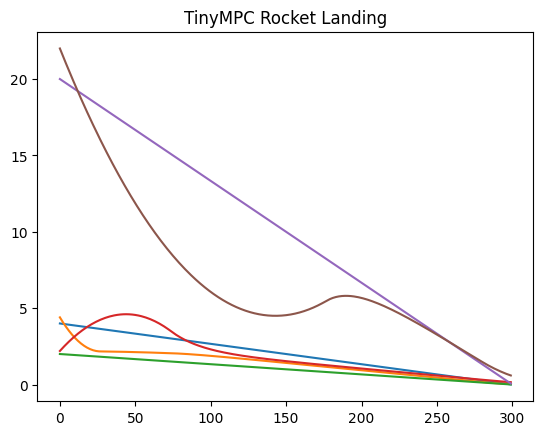

In [73]:
fig = plt.figure()
plot(Xref[1,1:NTOTAL-1]) # x
plot(Xhist[1,1:NTOTAL-1])
plot(Xref[2,1:NTOTAL-1]) # y
plot(Xhist[2,1:NTOTAL-1])
plot(Xref[3,1:NTOTAL-1]) # z
plot(Xhist[3,1:NTOTAL-1])
plt.title(opti * " Rocket Landing")
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

In [11]:
fig = plt.figure()
plot(Xref[1,1:NTOTAL-1]) # x
plot(Xhist[1,1:NTOTAL-1])
plot(Xref[2,1:NTOTAL-1]) # y
plot(Xhist[2,1:NTOTAL-1])
plot(Xref[3,1:NTOTAL-1]) # z
plot(Xhist[3,1:NTOTAL-1])
plt.title(opti * " Rocket Landing")
# put limit on axis
# plt.ylim(-5, 20)
# plt.xlim(0, 300)
fig

UndefVarError: UndefVarError: Xhist not defined

In [12]:
fig = plt.figure()
plot(Uhist[1,1:NTOTAL-1])
plot(Uhist[2,1:NTOTAL-1])
plot(Uhist[3,1:NTOTAL-1])
plt.title(opti * " Rocket Landing")
fig

UndefVarError: UndefVarError: Uhist not defined

In [13]:
fig = plt.figure()
plot(Uhist[1,1:NTOTAL-1])
plot(Uhist[2,1:NTOTAL-1])
plot(Uhist[3,1:NTOTAL-1])
plt.title(opti * " Rocket Landing")
fig

UndefVarError: UndefVarError: Uhist not defined

In [14]:
infoss

UndefVarError: UndefVarError: infoss not defined